## Initial Gas/Water Displacement
### Zach Murphy, Spring 2022

In [33]:
#imports
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import gas_density as rho_g # Temp IN C and Pressure in PSI
%matplotlib inline

In [34]:
# IMPORT DATA
df=pd.read_excel('ST120_gas-water.xlsx')
df['P avg']=(df['P up']+df['P down'])/2

In [35]:
# Gas Flow corrections 
#MFC - slight
mfc_to_ls=1.09
df['Gas in']=df['Gas in']*mfc_to_ls

#Flow meter - slight adjustment
meter_to_ls=.9975
df['Gas out']=df['Gas out']*meter_to_ls

In [36]:
# Core Parameters
L=7.62 #sample length (m)
r=0.00493/2 #sample radius (m)
A=m.pi*r**2 #sample area (m^2)
V_sample=A*L #sample volume (m^3)
por=.39 #sample porosity (-)
Vp=V_sample*por #sample pore volume (m^3)
Vp_ml=Vp*10**6
V_line=0 #volume of lines, fittings, etc
R=8.314 #gas constants (Pa m^3)/(mol k)
#Z=0.993 #compressibility factor of methane at STP

In [37]:
# Known Constants
Mm=0.01604 #MM of CH4 (kg/mol)
rho_h=912 #density of hydrate (kg/m^3)
Xwg=0; Xsg=0; Xmg=1 #mass fractions in gas phase (gas is pure methane) 
Xsh=0; Xmh=0.134; Xwh=0.866  #mass fractions in hydrate phase
Xml=0; Xsl=.035; Xwl=1-Xsl

In [38]:
# Initial Conditions
Sli=1 #intial liquid saturation
Sgi=0 # initial gas saturation
Shi=0 #initial hydrate saturation
Xsli=.035; Xwli=1-Xsli-Xml #Initial salinity of brine
P=df['P avg']; T=df['T'] #Initial temp and pressure
rho_l=1027.6 #kg/m^3 # !ASSUME TO BE CONSTANT BUT CAN ADD FUCTION TO UPDATE!
rho_gi,Zi=rho_g.CH4_EOS(T[1],P[1]) #initial gas density (kg/m^3) and Z
rho_gi=rho_gi*Mm

In [39]:
#  Initial Mass
mWi=(Xwli*Sli*rho_l+Xwh*Shi*rho_h+V_line*.000001*rho_l*Xwli)*Vp #mass of water (kg)
mMi=(Xml*Sli*rho_l+Xmg*Sgi*rho_gi+Xmh*Shi*rho_h)*Vp #mass of methane (kg)
mSi=(Xsli*Sli*rho_l+Xsg*Sgi*rho_gi+Xsh*Shi*rho_h)*Vp #mass of salt (kg)

In [40]:
# Gas density at each time step
df['rho_g_mol'],df['Z']=rho_g.CH4_EOS(df['T'],(df['P up'])) #density (mol/m3) and Z

df['rho_g']=df['rho_g_mol']*Mm #kg/m3

In [41]:
# mass in and mass out each time step
df['Gas in M']=df['Gas in']*6.681E-04
df['Gas out M']=df['Gas out']*6.681E-04

df['Water in M']=df['Water in']*.000001*rho_l*Xwli
df['Water out M']=df['Water out']*.000001*rho_l*Xwli

df['deltamM']=df['Gas in M'].diff()-df['Gas out M'].diff() #change in mass of gas in system (kg)
df['deltamW']=df['Water in M'].diff()-df['Water out M'].diff() #change in mass of water in system (kg)
df['deltamS']=df['deltamW']*Xsli #change in mass of salt (kg)

df=df.fillna(0)

In [42]:
# Mass at each time step
df['mM']=mMi+df['deltamM'].cumsum()
df['mW']=mWi+df['deltamW'].cumsum()
df['mS']=mSi+df['deltamS'].cumsum()

In [43]:
# Matrix to solve for Saturation
sat=pd.DataFrame(columns=['time','Sl','Sg','Sh'])
for i,row in df.iterrows():
    A=np.array([[1, 1, 1],
                [Xwl*rho_l, Xwg*df['rho_g'][i],Xwh*rho_h],
                [Xml*rho_l, Xmg*df['rho_g'][i], Xmh*rho_h]]) 
   
    B=np.array([1,df['mW'][i]/Vp,df['mM'][i]/Vp])
    X=np.linalg.solve(A,B)
    
    sat=sat.append({'Sh':X[2],'Sg':X[1],'Sl':X[0],'time':df['time'][i]},ignore_index=True)

In [44]:
df['Gas out PV']=(df['Gas out M']/df['rho_g'])/Vp
df['Gas in PV']=(df['Gas in M']/df['rho_g'])/Vp

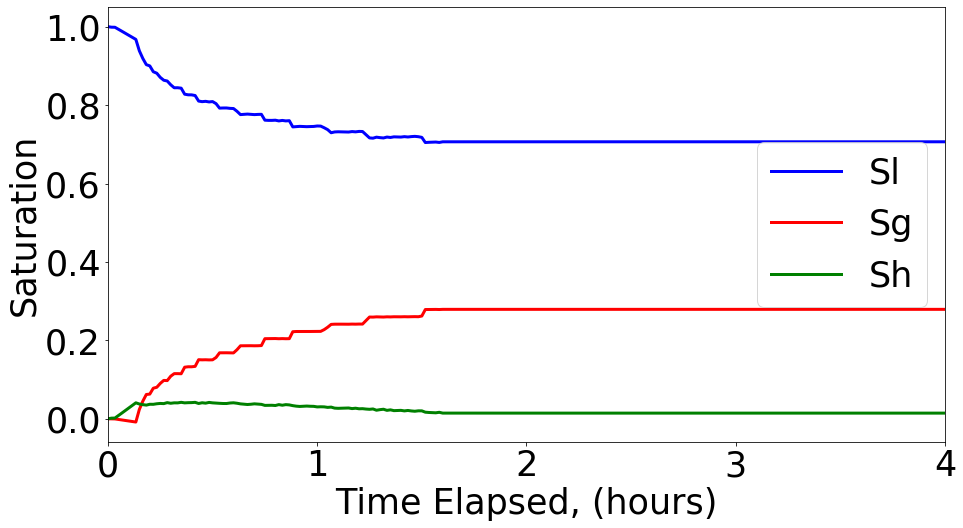

In [45]:
# Saturation vs Time
plt.figure(figsize=(15,8))
plt.rcParams['font.size']=35

plt.plot(sat['time'],sat['Sl'],label='Sl',linewidth=3,color='blue')
plt.plot(sat['time'],sat['Sg'],label='Sg',linewidth=3,color='red')
plt.plot(sat['time'],sat['Sh'],label='Sh',linewidth=3,color='green')
#plt.plot(sat['time'],sat['Sl']+sat['Sg'],label='Sg+Sl',linewidth=2,color='black')
plt.xlabel('Time Elapsed, (hours)')
plt.xlim([0,4])

#plt.ylim([0,1])
plt.ylabel('Saturation')
plt.legend(loc='best')

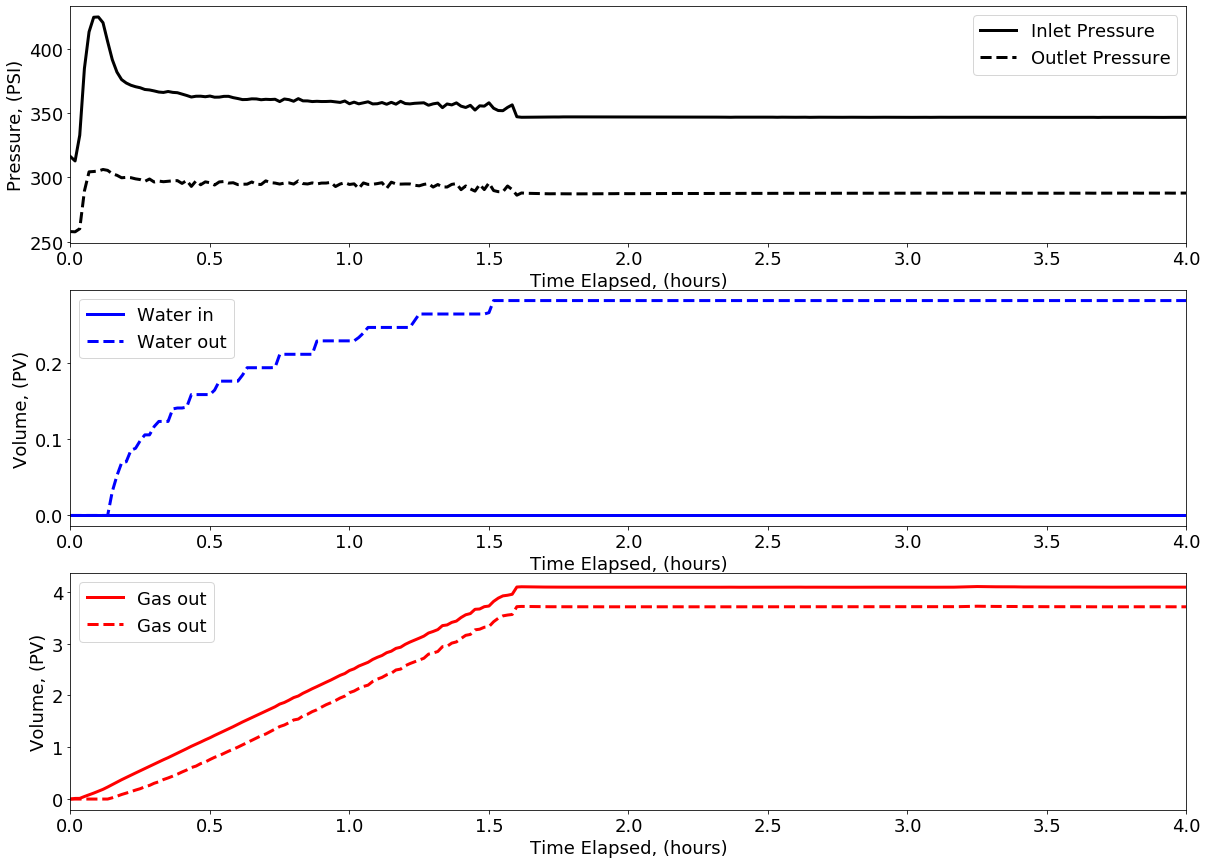

In [46]:
fig=plt.figure(figsize=(20,20))
plt.rcParams['font.size']=18
sharex='True'

plt1=fig.add_subplot(4,1,1)
plt1.plot(df['time'],df['P up'],label='Inlet Pressure',linewidth=3,color='black')
plt1.plot(df['time'],df['P down'],label='Outlet Pressure',linewidth=3,color='black',linestyle='dashed')
plt.xlim([0,4])
plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([250,800])
plt.ylabel('Pressure, (PSI)')
plt.legend(loc='best')

plt2=fig.add_subplot(4,1,2,sharex=plt1)
plt2.plot(df['time'],df['Water in']/Vp_ml,label='Water in',linewidth=3,color='blue')
plt2.plot(df['time'],df['Water out']/Vp_ml,label='Water out',linewidth=3,color='blue',linestyle='dashed')
plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([0,50])
plt.ylabel('Volume, (PV)')
plt.legend(loc='best')

plt3=fig.add_subplot(4,1,3,sharex=plt1)
plt3.plot(df['time'],df['Gas in PV'],label='Gas out',linewidth=3,color='red')
plt3.plot(df['time'],df['Gas out PV'],label='Gas out',linewidth=3,color='red',linestyle='dashed')
plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([0,0.006])
plt.ylabel('Volume, (PV)')
plt.legend(loc='best')

#plt4=fig.add_subplot(4,1,4,sharex=plt1)
#plt4.plot(df['time'],df['MFC measure'],label='Flow rate in',linewidth=3,color='red')
#plt4.plot(df['time'],df['MFC set'],label='Set point',linewidth=2,color='black',linestyle='dotted')
#plt4.plot(df['time'],df['Meter measure'],label='Flow rate out',linewidth=2,color='red',linestyle='dashed')
#plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([0,60])
#plt.ylabel('Qg, (sccm)')
#plt.legend(loc='best');

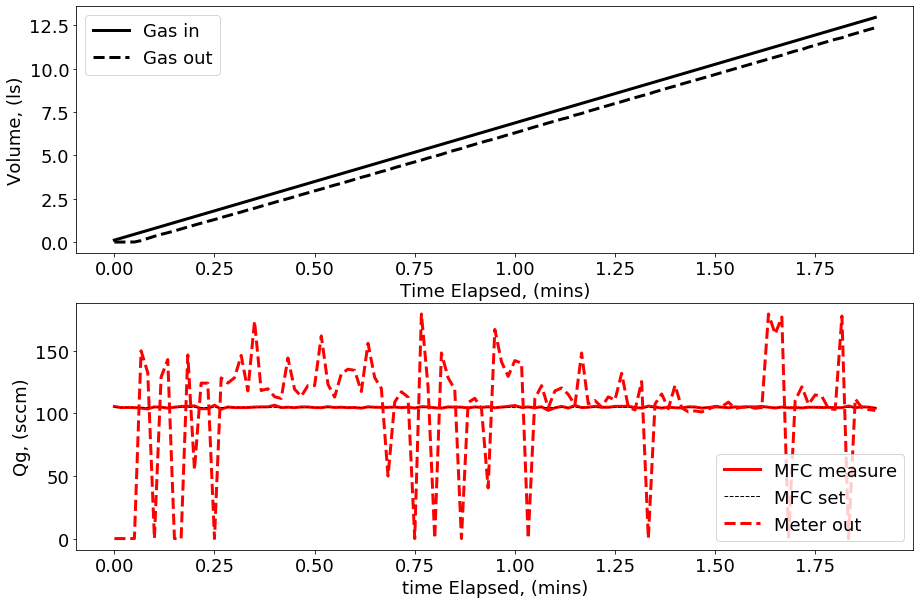

In [94]:
fig=plt.figure(figsize=(15,10))
plt.rcParams['font.size']=18
sharex='True'

plt1=fig.add_subplot(2,1,1)
plt1.plot(df['time'],df['Gas in'],label='Gas in',linewidth=3,color='black')
plt1.plot(df['time'],df['Gas out'],label='Gas out',linewidth=3,color='black',linestyle='dashed')
#plt.xlim([0,20])
plt.xlabel('Time Elapsed, (mins)')
#plt.ylim([0,2])
plt.ylabel('Volume, (ls)')
plt.legend(loc='best')

plt2=fig.add_subplot(2,1,2)
plt2.plot(df['time'],df['MFC measure'],label='MFC measure',linewidth=3,color='red')
plt2.plot(df['time'],df['MFC set'],label='MFC set',linewidth=1,color='black',linestyle='dashed')
plt2.plot(df['time'],df['Meter measure'],label='Meter out',linewidth=3,color='red',linestyle='dashed')
plt.xlabel('time Elapsed, (mins)')
#plt.ylim([0,100])
plt.ylabel('Qg, (sccm)')
plt.legend(loc='best')